### <span style = 'color: red;'><u><b>Warning:</b></u></span> This notebook takes approximately 23 minutes to run. 

# Introduction

In this project we use various recommendation strategies on a supplied dataset containing information about the users and their purchase history as well as other types of information which will be explored further in the report.

We performed most of our tasks in R and used Python to perform more intensive jobs on our dataset, mainly in the preprocessing phase.

# Loading the pre-processed Dataframe

Note: The pre-processing was done in a separate notebook, on Python.

In [1]:
library("recommenderlab")
library("dplyr")

Loading required package: Matrix

Loading required package: arules


Attaching package: ‘arules’


The following objects are masked from ‘package:base’:

    abbreviate, write


Loading required package: proxy


Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loading required package: registry

Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy


Attaching package: ‘dplyr’


The following objects are masked from ‘package:arules’:

    intersect, recode, setdiff, setequal, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
prim <- read.csv("sorted.csv")

In [3]:
#shuffle the dataframe
rows <- sample(nrow(prim))
aux <- prim[rows,]


sorted <- aux[,1:2]

# Task 2

### Popularity

We start with the simplest form of a recommendation system, the popularity based recommendation system. This system works simply by evaluating the most popular brands amongst all users in the training dataset and recommending the most popular ones to new users. By being the simplest and most intuitive one it has a great downfall of being impervious to the interests and taste of a particular user.

### Association Rules

Our  problem  is  a  classic  Market  Basket  Analysis  problem:   we  have  the  data  of  the  purchasesmade  by  a  group  of  users;  and  want  to  find  associations  between  sets  of  items  (rules)  using  theApriori algorithm. 

### Collaborative Filtering

Selecting the columns $'user\_id'$ and $'brand\_id'$, we can build a rating matrix, in which each rows corresponds to the encoding of different users (vector of size n, where the element i is the number of times the user bought the brand i) and each columns corresponds to the encoding of different brands (vector of size U, where the element j is the number of times the brand was bought the user i). It is important to notice that our matrix is not binary - one user can buy a brand more than one time.

Given the table, it easy to perform Collaborative filtering. The similarity between users and brands was measured using the Jaccard index, since it was found that it performed better in our data than the cosine similarity.

###  Determining the Best Parameters ( ~ 4m 10s )

We performed a preliminary analysis to determine which parameters maximizethe precision of the predictions while minimizing recall

AR run fold/sample [model time/prediction time]
	 1  [0.057sec/23.164sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.042sec/20.196sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.035sec/19.462sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.048sec/21.147sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.037sec/20.316sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.044sec/18.746sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.043sec/13.184sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.038sec/11.385sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.033sec/10.802sec] 


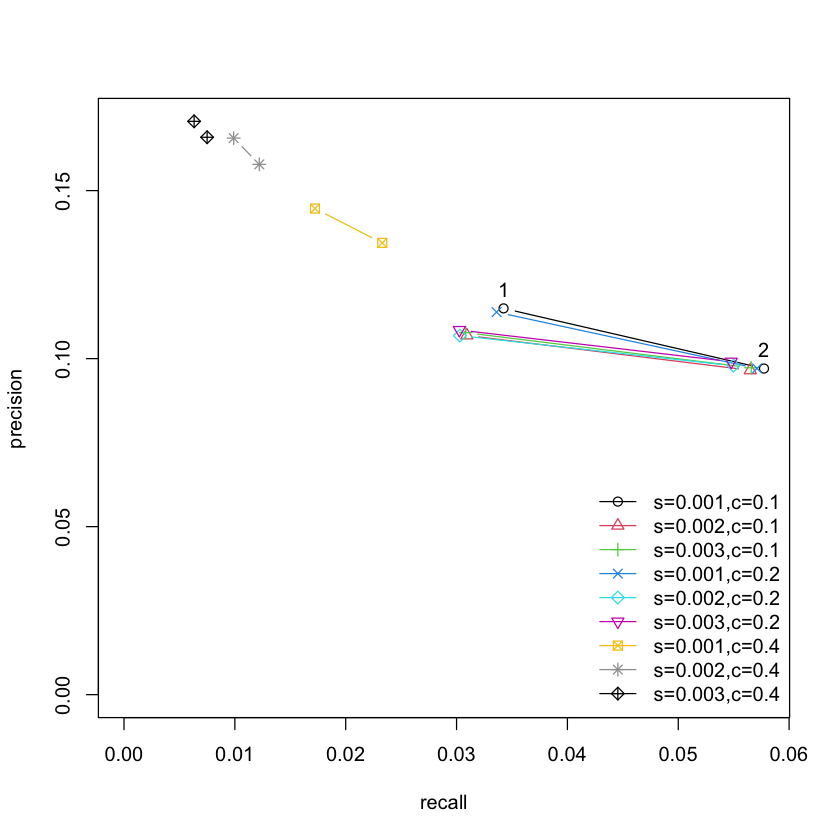

In [31]:
methods <- list(
"s=0.001,c=0.1" = list(name = "AR", param = list(supp = 0.001, confidence = 0.1)),
"s=0.002,c=0.1" = list(name = "AR", param = list(supp = 0.002, confidence = 0.1)),
"s=0.003,c=0.1" = list(name = "AR", param = list(supp = 0.003, confidence = 0.1)),
            
"s=0.001,c=0.2" = list(name = "AR", param = list(supp = 0.001, confidence = 0.2)),
"s=0.002,c=0.2" = list(name = "AR", param = list(supp = 0.002, confidence = 0.2)),
"s=0.003,c=0.2" = list(name = "AR", param = list(supp = 0.003, confidence = 0.2)),
            
"s=0.001,c=0.4" = list(name = "AR", param = list(supp = 0.001, confidence = 0.4)),
"s=0.002,c=0.4" = list(name = "AR", param = list(supp = 0.002, confidence = 0.4)),
"s=0.003,c=0.4" = list(name = "AR", param = list(supp = 0.003, confidence = 0.4))
                      
            )
                        



brm <- as(sorted, "binaryRatingMatrix")
brm <- brm[rowCounts(brm) > 7]
brme <- evaluationScheme(brm, method = "split", train = 0.8, given = 6)
arresult <- evaluate(brme,methods, type = "topNList",n = c(1,2))
plot(arresult,"prec/rec", annotate = TRUE)

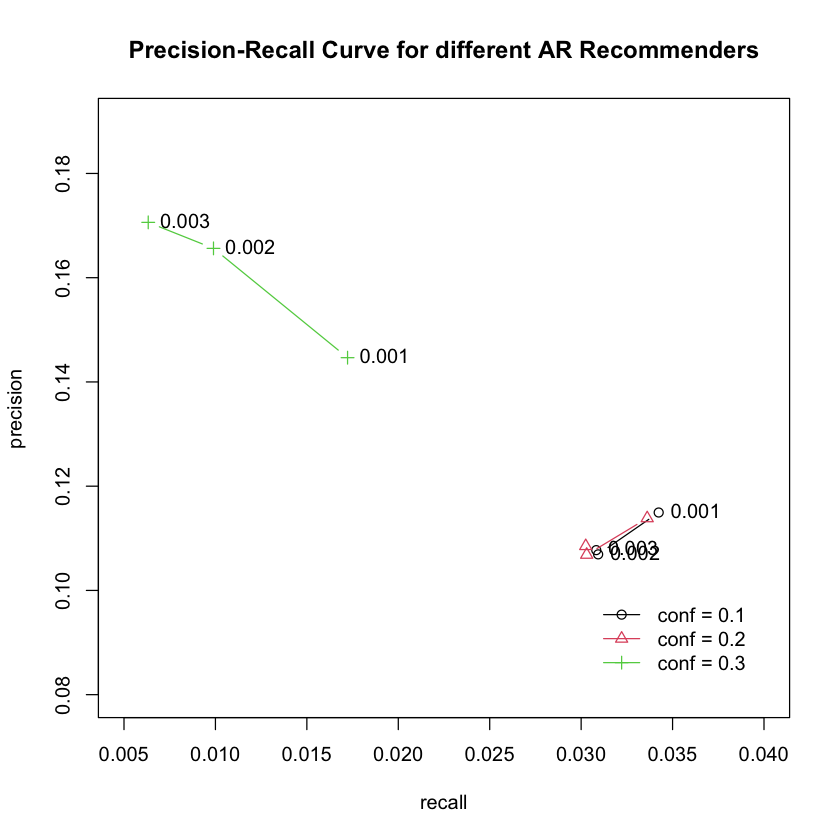

In [39]:
colunas = c('TP','FP','FN','TN','N','precision','recall','TPR','FPR','n')
supp = c(0.001,0.002,0.003)
conf = c(0.1,0.2,0.3)
ffinal <-as.data.frame(matrix(0,9,4))
colnames(ffinal) <- c('precision','recall','supp','conf')
for (i in 0:2){
    
    for (j in 0:2){
        c1 <- as.data.frame(avg(arresult)[i*3+j+1])
        colnames(c1) <- colunas
        c2 <- c1[1,c('precision','recall')]
        c2['supp'] = supp[j+1]
        c2['conf'] = conf[i+1]
        ffinal[i*3+j+1,] = c2
        
    }
}

ffinal1 <- subset(ffinal, conf == 0.1)
ffinal2 <- subset(ffinal, conf == 0.2)
ffinal3 <- subset(ffinal, conf == 0.3)
plot(ffinal1[c("recall","precision")],main = "Precision-Recall Curve for different AR Recommenders",type='b',xlim=c(0.005,0.04),ylim=c(0.08,0.19))

text( ffinal1[c("recall","precision")],label = ffinal1$supp, pos = 4 )

lines(ffinal2[c("recall","precision")],type = 'b',pch=2,col = 2)

lines(ffinal3[c("recall","precision")],type = 'b',pch=3,col = 3)

text( ffinal3[c("recall","precision")],label = ffinal3$supp, pos = 4 )

legend("bottomright", inset = 0.05,
       legend = c("conf = 0.1", "conf = 0.2",'conf = 0.3'),
       bg = rgb(1, 0, 0, alpha = 0), # Legend background color
       box.col = "white",
       lty = 1,
       col = 1:3,
       pch = 1:3)

While for higher confidence $c = 0.3$ the results seem more precise, they do return less recall then for lower confidence values. This is expected however, since increasing confidence creates better but fewer rules, which will increase accuracy and precision on the recommendations made but, having less rules, the number of recommendations decreases, which in turn decreases recall. For this reason, we will choose a support value of $0.001$ and a confidence of $0.2$, since these seem to offer the best precision-recall ratio. 

## ROC Curves for Hypothesis Testing (~ 2m 30s)

In order to refute the null hypothesis that our recommendation methods are entirely random we will analyse the Receiver Operating Characteristic (ROC) curves that characterize each of our methods. Let's remember that a strictly random recommender will have a TPR(FPR) curve that'll be a straight line with a slope of 1.

In [41]:
methods <- list(
"popular" = list(name = "POPULAR", param = NULL),
"UB-CF" = list(name = "UBCF", param = NULL),
"IB-CF" = list(name = "IBCF", param = NULL),
"AR" = list(name = "AR", param = list(supp = 0.001, confidence = 0.2))
)

brm <- as(sorted, "binaryRatingMatrix")
brm <- brm[rowCounts(brm) > 6]
brme <- evaluationScheme(brm, method = "split", train = 0.8, given = 3)
result <- evaluate(brme,methods, type = "topNList",n = c(1,50,100,150,200,400,1000))

POPULAR run fold/sample [model time/prediction time]
	 1  [0.003sec/6.348sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/62.205sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [32.201sec/1.579sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.057sec/31.985sec] 


The ROC curves for with different evaluation protocols are represented in the following figures: 

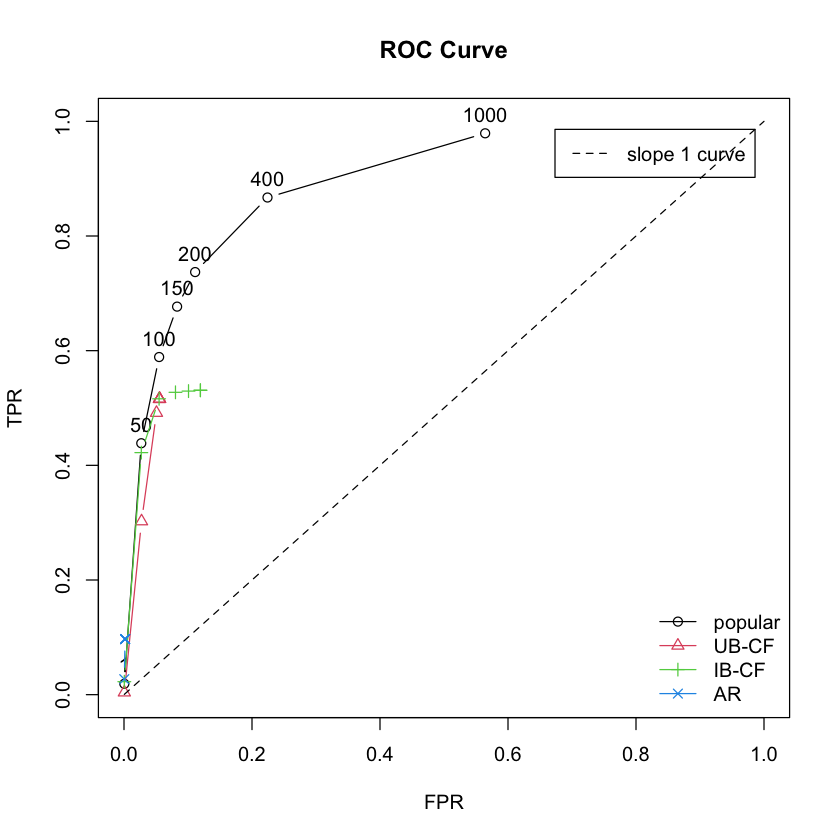

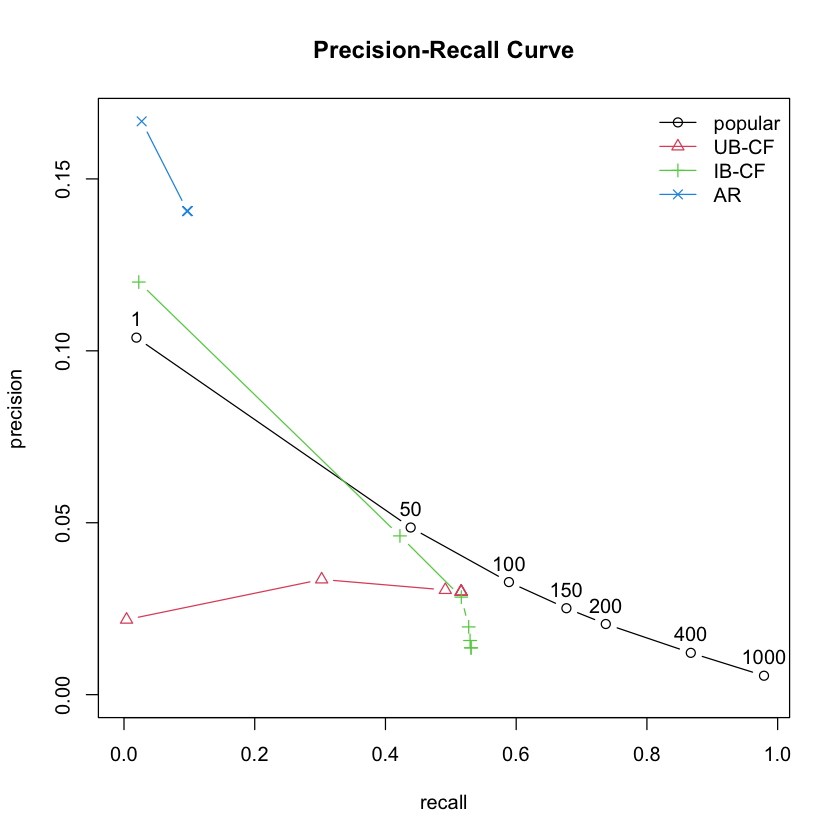

In [42]:
x <- c(0.0005,1)
plot(result,main = 'ROC Curve', annotate = TRUE,xlim = c(0,1),ylim = c(0,1))
lines(x,x,lty = 2)
legend('topright',inset = 0.05,legend = 'slope 1 curve',lty = 2)
title(main = 'ROC Curve')
plot(result,main = 'Precision-Recall Curve', "prec/rec",legend = 'topright', annotate = TRUE)
title(main = 'Precision-Recall Curve')

It can be argued that distinct methods, since their ROC curves are so similar, must be in fact the same recommender system. That can be tested by comparing the area between the curves of two different methods. However, there is no need to do that, because if the null hypothesis in this case is indeed true (the recommender systems are learning the same rules) that is not necessarily bad (In a perfect case all the models would have the same ROC curve, because they would learn the optimal rules).

In [43]:
setEPS()                                            
postscript("cross_val_AR_ROC.eps")         
x <- c(0.0005,1)
plot(result,main = 'ROC Curve', annotate = TRUE,xlim = c(0,1),ylim = c(0,1))
lines(x,x,lty = 2)
legend('topright',inset = 0.05,legend = 'slope 1 curve',lty = 2)
title(main = 'ROC Curve')
dev.off()                 

                                           

setEPS()                                            
postscript("cross_val_AR_ROC.eps")                       
plot(result,main = 'Precision-Recall Curve', "prec/rec",legend = 'topright', annotate = TRUE)
title(main = 'Precision-Recall Curve')
dev.off()                 

pdf 
  2

pdf 
  2

## Comparing Methods for Different Evaluation Protocols

### Split

#### given = 3 (~ 2m 30s)

POPULAR run fold/sample [model time/prediction time]
	 1  [0.004sec/5.441sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/57.566sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [29.961sec/1.092sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.054sec/29.057sec] 


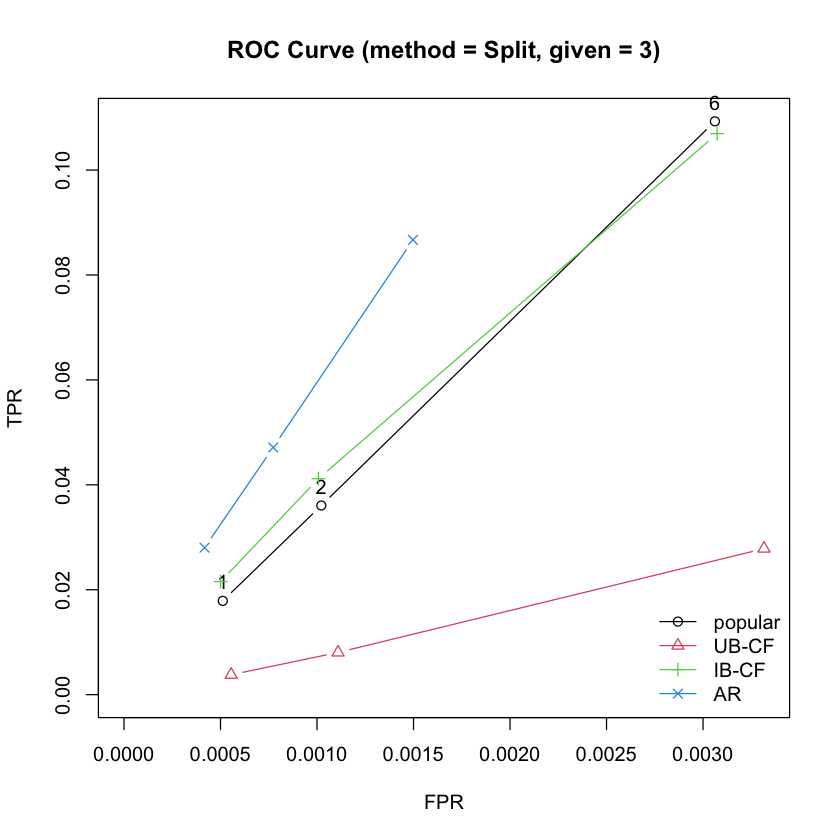

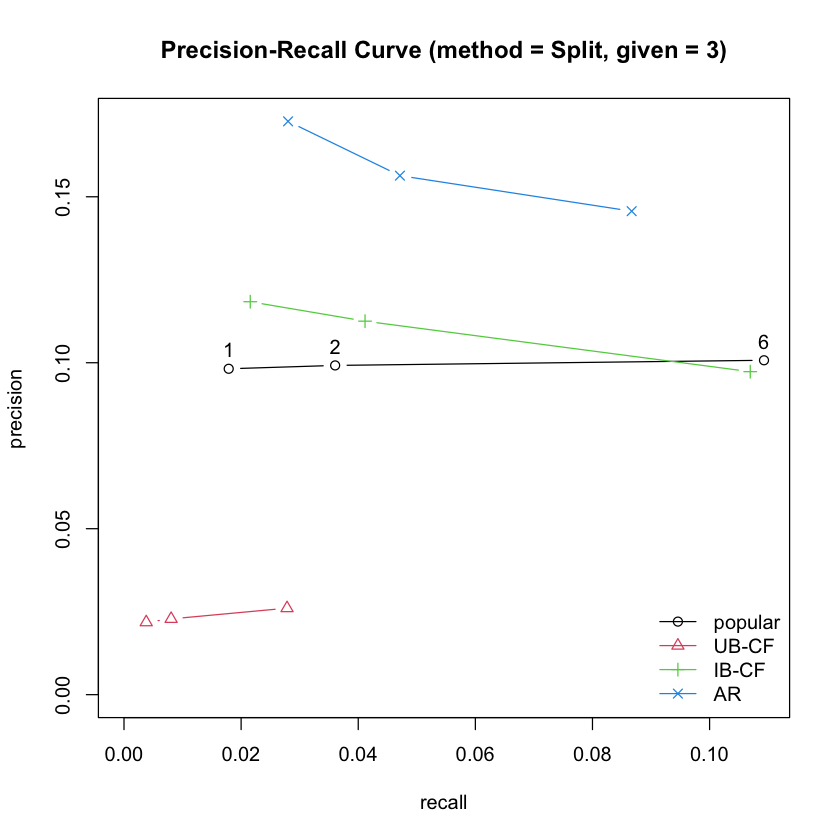

In [44]:
methods <- list(
"popular" = list(name = "POPULAR", param = NULL),
"UB-CF" = list(name = "UBCF", param = NULL),
"IB-CF" = list(name = "IBCF", param = NULL),
"AR" = list(name = "AR", param = list(supp = 0.001, confidence = 0.2))
)

brm <- as(sorted, "binaryRatingMatrix")
brm <- brm[rowCounts(brm) > 6]
brme <- evaluationScheme(brm, method = "split", train = 0.8, given = 3)
split3 <- evaluate(brme,methods, type = "topNList",n = c(1,2,6))

plot(split3,main = 'ROC Curve (method = Split, given = 3)', annotate = TRUE)
title(main = 'ROC Curve (method = Split, given = 3)')
plot(split3,main = 'Precision-Recall Curve (method = Split, given = 3)',"prec/rec", annotate = TRUE)
title(main = 'Precision-Recall Curve (method = Split, given = 3)')

#### given = 6 (~ 3m 30s)

POPULAR run fold/sample [model time/prediction time]
	 1  [0.003sec/5.39sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/59.295sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [33.747sec/1.441sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.052sec/31.028sec] 


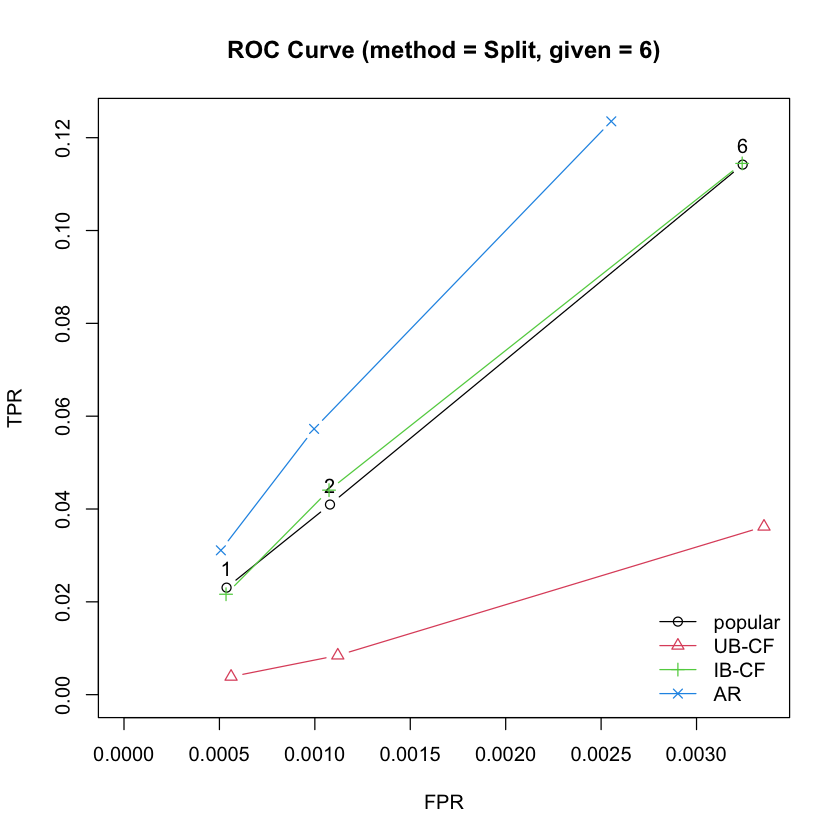

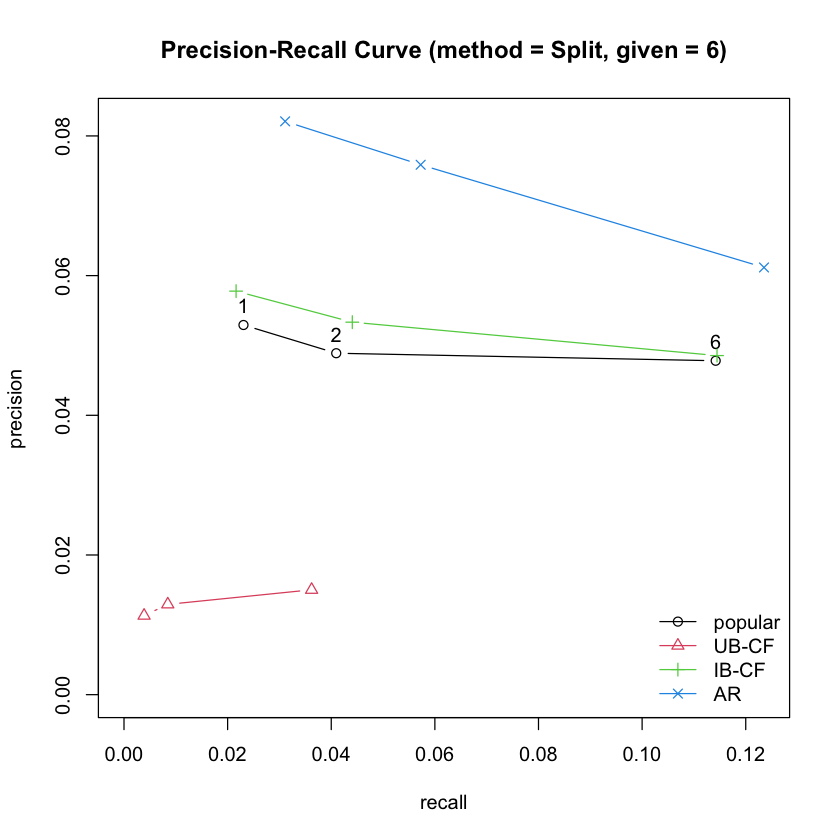

In [45]:
methods <- list(
"popular" = list(name = "POPULAR", param = NULL),
"UB-CF" = list(name = "UBCF", param = NULL),
"IB-CF" = list(name = "IBCF", param = NULL),
"AR" = list(name = "AR", param = list(supp = 0.001, confidence = 0.2))
)

brm <- as(sorted, "binaryRatingMatrix")
brm <- brm[rowCounts(brm) > 6]
brme <- evaluationScheme(brm, method = "split", train = 0.8, given = 6)
split6 <- evaluate(brme,methods, type = "topNList",n = c(1,2,6))

plot(split6,main = 'ROC Curve (method = Split, given = 6)', annotate = TRUE)
title(main = 'ROC Curve (method = Split, given = 6)')
plot(split6,main = 'Precision-Recall Curve (method = Split, given = 6)',"prec/rec", annotate = TRUE)
title(main = 'Precision-Recall Curve (method = Split, given = 6)')

### Cross-Validation

#### given = 3 (~ 8m)

POPULAR run fold/sample [model time/prediction time]
	 1  [0.004sec/2.406sec] 
	 2  [0.004sec/2.516sec] 
	 3  [0.003sec/2.826sec] 
	 4  [0.004sec/2.46sec] 
	 5  [0.005sec/2.518sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/34.329sec] 
	 2  [0.002sec/36.66sec] 
	 3  [0.002sec/35.309sec] 
	 4  [0.001sec/34.381sec] 
	 5  [0.001sec/34.189sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [36.842sec/0.585sec] 
	 2  [37.697sec/0.558sec] 
	 3  [35.186sec/0.505sec] 
	 4  [36.053sec/0.468sec] 
	 5  [37.699sec/0.848sec] 
AR run fold/sample [model time/prediction time]
	 1  [0.064sec/14.464sec] 
	 2  [0.055sec/15.016sec] 
	 3  [0.066sec/14.457sec] 
	 4  [0.056sec/14.046sec] 
	 5  [0.056sec/14.976sec] 


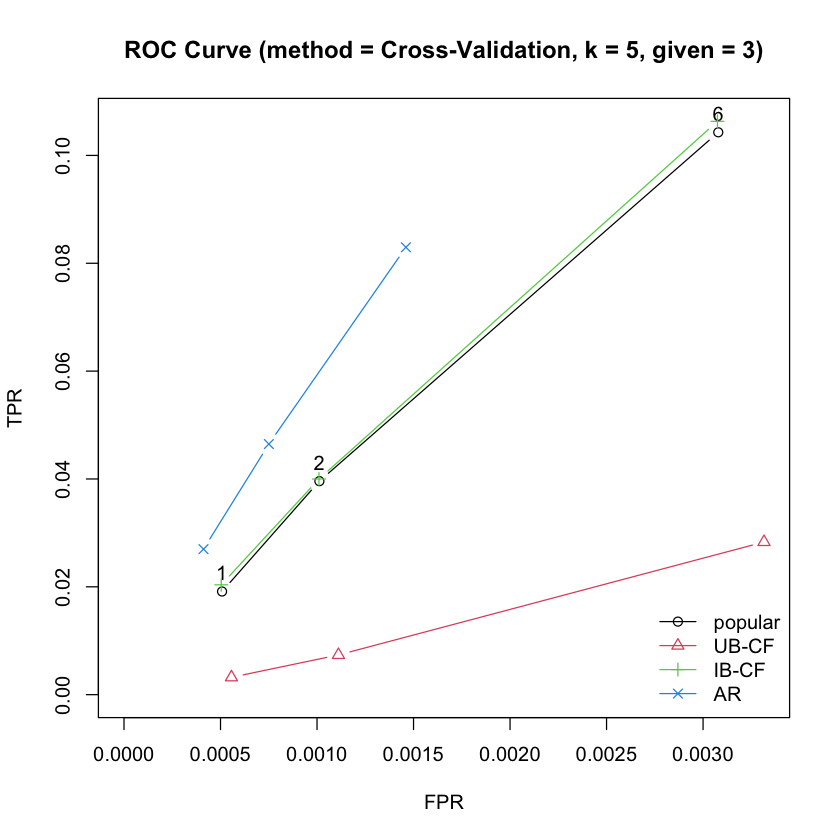

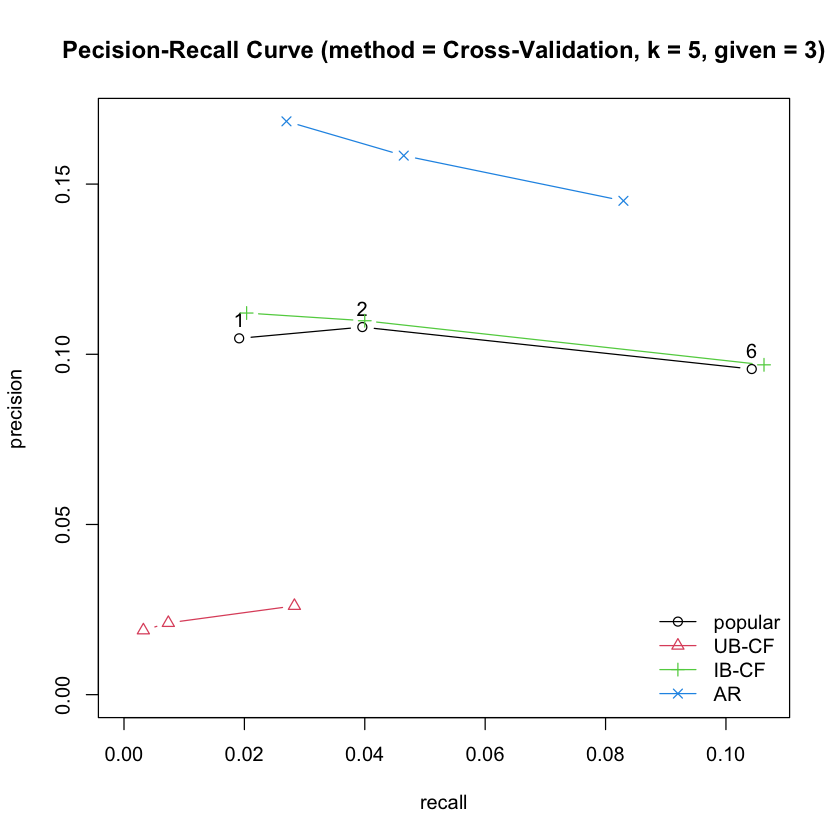

In [46]:
methods <- list(
"popular" = list(name = "POPULAR", param = NULL),
"UB-CF" = list(name = "UBCF", param = NULL),
"IB-CF" = list(name = "IBCF", param = NULL),
"AR" = list(name = "AR", param = list(supp = 0.001, confidence = 0.2))
)

brm <- as(sorted, "binaryRatingMatrix")
brm <- brm[rowCounts(brm) > 6]
brme <- evaluationScheme(brm, method = "split", k=5, given = 3)
cross3 <- evaluate(brme,methods, type = "topNList",n = c(1,2,6))

plot(cross3, annotate = TRUE)
title(main = 'ROC Curve (method = Cross-Validation, k = 5, given = 3)')
plot(cross3,"prec/rec", annotate = TRUE)
title(main = 'Pecision-Recall Curve (method = Cross-Validation, k = 5, given = 3)')

The results seem to be consistent, independently of the evaluation method: The Association Rules method performs the best, Item-Based Collaborative Filtering comes slightly above the Popularity method and User-Based Collaborative Filtering performs the worst both in terms of precision and recall. According to 'The Importance of Brand Affinity(...)', the Collaborative Filtering methods are actually expected to fail given the context of the data. Since we're handling data from the Luxury fashion market, customers from this area tend to have high demands for exclusive products, which leads to an increasing of the difference between users and items in terms of the user-item matrix. AR, however, is a bit more versatile in this aspect, since it eliminates these transactions for not presenting enough support.

## Example of methods used in a set of users

### Popularity

We can implement a recommendation system using the popularity method, train it with a set of our data and then use this model to predict the purchases for some other set of users. In this case we used the first 60000 users in our dataset to train the model and made predictions for the next two users

In [13]:
d_train <- brm[rowCounts(brm) > 2][1:60000,]
pop <- Recommender(d_train, method="POPULAR")

count <- 0
tot <- 0

for (i in 60010:60011){
    u <- brm[rowCounts(brm) > 2][i,]
    pred <- predict(pop,u)
    d_user <- u
    l <- getList(pred)
    user <- as(d_user,"data.frame")
    print('Brand purchased')
    print(user['item'])
    print('-----------')
    print('Predicted')
    print(l)
    print('-----------')
}

[1] "Brand purchased"
      item
1  9888236
2 17040449
3 25482207
4 33603020
5 61641134
6 73388933
7 93353161
[1] "-----------"
[1] "Predicted"
$`234985`
 [1] "89083147" "71542943" "89700300" "13030587" "51215738" "33008187"
 [7] "26715155" "36189858" "44642891" "97371635"

[1] "-----------"
[1] "Brand purchased"
      item
1 63078600
2 71542943
3 90713862
4 91773135
[1] "-----------"
[1] "Predicted"
$`234986`
 [1] "89083147" "89700300" "33603020" "13030587" "51215738" "33008187"
 [7] "26715155" "36189858" "44642891" "97371635"

[1] "-----------"
[1] "Brand purchased"
      item
1 18712138
2 25176687
3 44642891
4 56772583
5 89083147
6 92850413
7 93702652
[1] "-----------"
[1] "Predicted"
$`234989`
 [1] "71542943" "89700300" "33603020" "13030587" "51215738" "33008187"
 [7] "26715155" "36189858" "97371635" "52029885"

[1] "-----------"


As we can see, none of the top10 predictions matched the real brands purchased by our users. 

### Assotiation Rules

As an example, applying the AR method to the whole dataset gives us the following set of rules: 

In [4]:
brm <- as(sorted, "binaryRatingMatrix")
model <- Recommender(brm, method = 'AR', parameter = list(supp = 0.003, confidence = 0.1))
rules <- getModel(model)$rule_base
inspect(rules)

    lhs           rhs        support     confidence coverage   lift     count
[1] {93702652} => {71542943} 0.003444578 0.1292750  0.02664536 2.939157 1134 
[2] {67196564} => {51215738} 0.003335227 0.1251710  0.02664536 2.966519 1098 
[3] {52029885} => {89083147} 0.003465841 0.1126135  0.03077643 2.064589 1141 


It is evident that such a small set of rules won't be of much help in such a large dataset.

### User-based Collaborative Filtering

Once again we can visualize the method we implemented by using it to predict the brands purchased by introducing a subset of users into our system and recommending brands using our model. Then we can compare these predictions with the actual brands purchased. 

In [18]:
ubcf <- Recommender(d_train, method="UBCF")
d_train <- brm[rowCounts(brm) > 2][1:60000,]
for (i in 60010:60012){
    d_user <- brm[rowCounts(brm) > 2][i,]
    pred <- predict(ubcf,d_user)
    l <- getList(pred)
    user <- as(d_user,"data.frame")
    print('Brand purchased')
    print(user['item'])
    print('-----------')
    print('Predicted')
    print(l)
    print('-----------')
}

[1] "Brand purchased"
      item
1  9888236
2 17040449
3 25482207
4 33603020
5 61641134
6 73388933
7 93353161
[1] "-----------"
[1] "Predicted"
$`234985`
 [1] "66845244" "14354152" "34052017" "53874831" "48210076" "48621284"
 [7] "90713862" "36189858" "41780735" "78170210"

[1] "-----------"
[1] "Brand purchased"
      item
1 63078600
2 71542943
3 90713862
4 91773135
[1] "-----------"
[1] "Predicted"
$`234986`
 [1] "1286566"  "28590875" "33582582" "97371635" "31552083" "36189858"
 [7] "77994709" "7014181"  "27968276" "89700300"

[1] "-----------"
[1] "Brand purchased"
      item
1 18712138
2 25176687
3 44642891
4 56772583
5 89083147
6 92850413
7 93702652
[1] "-----------"
[1] "Predicted"
$`234989`
[1] "41343326" "51215738" "71542943" "21265393" "31216129" "34720751" "80735391"
[8] "91788434"

[1] "-----------"


### Item-based Collaborative Filtering 

In [17]:
ibcf <- Recommender(d_train, method="IBCF")
d_train <- brm[rowCounts(brm) > 2][1:60000,]
for (i in 60010:60012){
    d_user <- brm[rowCounts(brm) > 2][i,]
    pred <- predict(ibcf,d_user)
    l <- getList(pred)
    user <- as(d_user,"data.frame")
    print('Brand purchased')
    print(user['item'])
    print('-----------')
    print('Predicted')
    print(l)
    print('-----------')
}

[1] "Brand purchased"
      item
1  9888236
2 17040449
3 25482207
4 33603020
5 61641134
6 73388933
7 93353161
[1] "-----------"
[1] "Predicted"
$`234985`
 [1] "78170210" "36189858" "44642891" "13030587" "89700300" "89083147"
 [7] "71542943" "92850413" "53874831" "26715155"

[1] "-----------"
[1] "Brand purchased"
      item
1 63078600
2 71542943
3 90713862
4 91773135
[1] "-----------"
[1] "Predicted"
$`234986`
 [1] "93702652" "13030587" "33603020" "7014181"  "36189858" "89083147"
 [7] "89700300" "26715155" "58852586" "44642891"

[1] "-----------"
[1] "Brand purchased"
      item
1 18712138
2 25176687
3 44642891
4 56772583
5 89083147
6 92850413
7 93702652
[1] "-----------"
[1] "Predicted"
$`234989`
 [1] "71542943" "89700300" "13030587" "7014181"  "33603020" "26715155"
 [7] "52029885" "26493521" "31881992" "33008187"

[1] "-----------"


As we can see, these methods don't have a very high accuracy (also due to the nature of our dataset), specially when we pick a very small subset of users it is very unlikely that our predictions will be accurate.

# Task 3

Since the market at hand is so unique, it could be useful to try to use introduce additional information into our recommender in an effort to boost our results. In addition to the \textit{user\_id} and \textit{brand\_id}, we also have acess to the user's country, the platform where the transaction was completed, the purchase date, user segment and the sale applied to the product. 

Our attempt at a context-aware recommendation system consists in forming clusters of users by some parameter (e.g country) and assuming that users in the same clusters are much more correlated to each other than to users of different groups. If this assumption is verified, we can reduce the user-item matrix of the dataset to the user-item matrices of each cluster, hereby reducing computation time and potentially increasing the quality of our results. For example, the fashion rules of a certain country could condition users from that country to buy more of some certain products and, because of this, users from other countries could be erroneously recommended some brands just for buying similar products.

To get the results of such a recommendation system, we divide the dataset by either country or platform and apply the \textit{evaluate} function from the \textit{recommenderlab} library with both Item-Based and User-Based Collaborative Filtering methods to each of the obtained subsets. We then sum all of the TP, FP, TN and FN from all the substets to obtain ROC and Precision-Recall curves of the recommender. These curves for division by either country or platform using either User-based or Item-based CF are shown below:

## By Country

### User-Based Collaborative Filtering ( ~ 20s)

In [13]:
final1 <- as.data.frame(matrix(0,3,5))
colnames(final1) <- c("TP","FP","FN","TN","N")

for (i in unique(prim[,"country"])){
    
    part <- subset(prim, country == i,c("user_id","brand_id"))    
    brm <- as(part, "binaryRatingMatrix")
    brm <- brm[rowCounts(brm) > 6]
    
    if (nrow(brm) > 1){
        print(i)
        brme <- evaluationScheme(brm, method = "split", train = 0.8, given = 3)
        results <- evaluate(brme,"UBCF", type = "topNList",n = c(1,2,6))
        conf <- as.data.frame(getConfusionMatrix(results))[c("TP","FP","FN","TN","N")]
        final1 <- final1 + conf
        
    }
}

final1["precision"] = final1["TP"]/(final1["TP"]+final1["FP"])
final1["recall"] = final1["TP"]/(final1["TP"]+final1["FN"])
final1["TPR"] = final1["recall"]
final1["FPR"] = final1["FP"]/(final1["FP"]+final1["TN"])
final1["n"] = c(1,2,6)



[1] 2
UBCF run fold/sample [model time/prediction time]
	 1  [0.002sec/0.104sec] 
[1] 108
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/0.629sec] 
[1] 118
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/4.42sec] 
[1] 59
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/0.322sec] 
[1] 4
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.08sec] 
[1] 181
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.395sec] 
[1] 74
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/1.505sec] 
[1] 105
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/0.214sec] 
[1] 37
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/1.417sec] 
[1] 9
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/0.416sec] 
[1] 125
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/1.387sec] 
[1] 90
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/0.445sec] 
[1] 73
UBCF 

### Item-Based Collaborative Filtering ( ~ 30s)

In [14]:
final2 <- as.data.frame(matrix(0,3,5))
colnames(final2) <- c("TP","FP","FN","TN","N")

for (i in unique(prim[,"country"])){
    
    part <- subset(prim, country == i,c("user_id","brand_id"))    
    brm <- as(part, "binaryRatingMatrix")
    brm <- brm[rowCounts(brm) > 6]
    
    if (nrow(brm) > 1){
        print(i)
        brme <- evaluationScheme(brm, method = "split", train = 0.8, given = 3)
        results <- evaluate(brme,"IBCF", type = "topNList",n = c(1,2,6))
        conf <- as.data.frame(getConfusionMatrix(results))[c("TP","FP","FN","TN","N")]
        final2 <- final2 + conf
        
    }
}

final2["precision"] = final2["TP"]/(final2["TP"]+final2["FP"])
final2["recall"] = final2["TP"]/(final2["TP"]+final2["FN"])
final2["TPR"] = final2["recall"]
final2["FPR"] = final2["FP"]/(final2["FP"]+final2["TN"])
final2["n"] = c(1,2,6)



[1] 2
IBCF run fold/sample [model time/prediction time]
	 1  [0.22sec/0.009sec] 
[1] 108
IBCF run fold/sample [model time/prediction time]
	 1  [1.059sec/0.032sec] 
[1] 118
IBCF run fold/sample [model time/prediction time]
	 1  [5.666sec/0.164sec] 
[1] 59
IBCF run fold/sample [model time/prediction time]
	 1  [0.397sec/0.019sec] 
[1] 4
IBCF run fold/sample [model time/prediction time]
	 1  [0.214sec/0.013sec] 
[1] 181
IBCF run fold/sample [model time/prediction time]
	 1  [0.596sec/0.022sec] 
[1] 74
IBCF run fold/sample [model time/prediction time]
	 1  [2.421sec/0.083sec] 
[1] 105
IBCF run fold/sample [model time/prediction time]
	 1  [0.321sec/0.014sec] 
[1] 37
IBCF run fold/sample [model time/prediction time]
	 1  [2.127sec/0.108sec] 
[1] 9
IBCF run fold/sample [model time/prediction time]
	 1  [0.72sec/0.024sec] 
[1] 125
IBCF run fold/sample [model time/prediction time]
	 1  [2.036sec/0.071sec] 
[1] 90
IBCF run fold/sample [model time/prediction time]
	 1  [0.787sec/0.029sec] 
[1] 

## By Platform

### User-Based Collaborative Filtering ( ~ 30s)

In [15]:
final3 <-as.data.frame(matrix(0,3,5))
colnames(final3) <- c("TP","FP","FN","TN","N")

for (i in unique(prim[,"platform"])){
    
    part <- subset(prim, platform == i,c("user_id","brand_id"))    
    brm <- as(part, "binaryRatingMatrix")
    brm <- brm[rowCounts(brm) > 6]
    
    if (nrow(brm) > 1){
        print(i)
        brme <- evaluationScheme(brm, method = "split", train = 0.8, given = 6)
        result <- evaluate(brme,"UBCF", type = "topNList",n = c(1,2,6))
        conf <- as.data.frame(getConfusionMatrix(result))[c("TP","FP","FN","TN","N")]
        final3 <- final3 + conf
        
    }
}

final3["precision"] = final3["TP"]/(final3["TP"]+final3["FP"])
final3["recall"] = final3["TP"]/(final3["TP"]+final3["FN"])
final3["TPR"] = final3["recall"]
final3["FPR"] = final3["FP"]/(final3["FP"]+final3["TN"])
final3["n"] = c(1,2,6)



[1] 59713904
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/12.625sec] 
[1] 35279833
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/9.956sec] 
[1] 39857033
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/1.112sec] 
[1] 24380949
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/0.029sec] 
[1] 82921252
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/0.359sec] 
[1] 50298854
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/0.096sec] 
[1] 34959346
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.152sec] 
[1] 54454273
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.035sec] 
[1] 22734142
UBCF run fold/sample [model time/prediction time]
	 1  [0.001sec/0.008sec] 
[1] 15766995
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.008sec] 


### Item-Based Collaborative Filtering ( ~ 30s)

In [16]:
final4 <-as.data.frame(matrix(0,3,5))
colnames(final4) <- c("TP","FP","FN","TN","N")

for (i in unique(prim[,"platform"])){
    
    part <- subset(prim, platform == i,c("user_id","brand_id"))    
    brm <- as(part, "binaryRatingMatrix")
    brm <- brm[rowCounts(brm) > 6]
    
    if (nrow(brm) > 1){
        print(i)
        brme <- evaluationScheme(brm, method = "split", train = 0.8, given = 6)
        result <- evaluate(brme,"IBCF", type = "topNList",n = c(1,2,6))
        conf <- as.data.frame(getConfusionMatrix(result))[c("TP","FP","FN","TN","N")]
        final4 <- final4 + conf
        
    }
}

final4["precision"] = final4["TP"]/(final4["TP"]+final4["FP"])
final4["recall"] = final4["TP"]/(final4["TP"]+final4["FN"])
final4["TPR"] = final4["recall"]
final4["FPR"] = final4["FP"]/(final4["FP"]+final4["TN"])
final4["n"] = c(1,2,6)



[1] 59713904
IBCF run fold/sample [model time/prediction time]
	 1  [11.88sec/0.489sec] 
[1] 35279833
IBCF run fold/sample [model time/prediction time]
	 1  [11.084sec/0.432sec] 
[1] 39857033
IBCF run fold/sample [model time/prediction time]
	 1  [1.913sec/0.073sec] 
[1] 24380949
IBCF run fold/sample [model time/prediction time]
	 1  [0.22sec/0.009sec] 
[1] 82921252
IBCF run fold/sample [model time/prediction time]
	 1  [0.844sec/0.046sec] 
[1] 50298854
IBCF run fold/sample [model time/prediction time]
	 1  [0.271sec/0.014sec] 
[1] 34959346
IBCF run fold/sample [model time/prediction time]
	 1  [0.327sec/0.015sec] 
[1] 54454273
IBCF run fold/sample [model time/prediction time]
	 1  [0.11sec/0.007sec] 
[1] 22734142
IBCF run fold/sample [model time/prediction time]
	 1  [0.014sec/0.009sec] 
[1] 15766995
IBCF run fold/sample [model time/prediction time]
	 1  [0.01sec/0.008sec] 


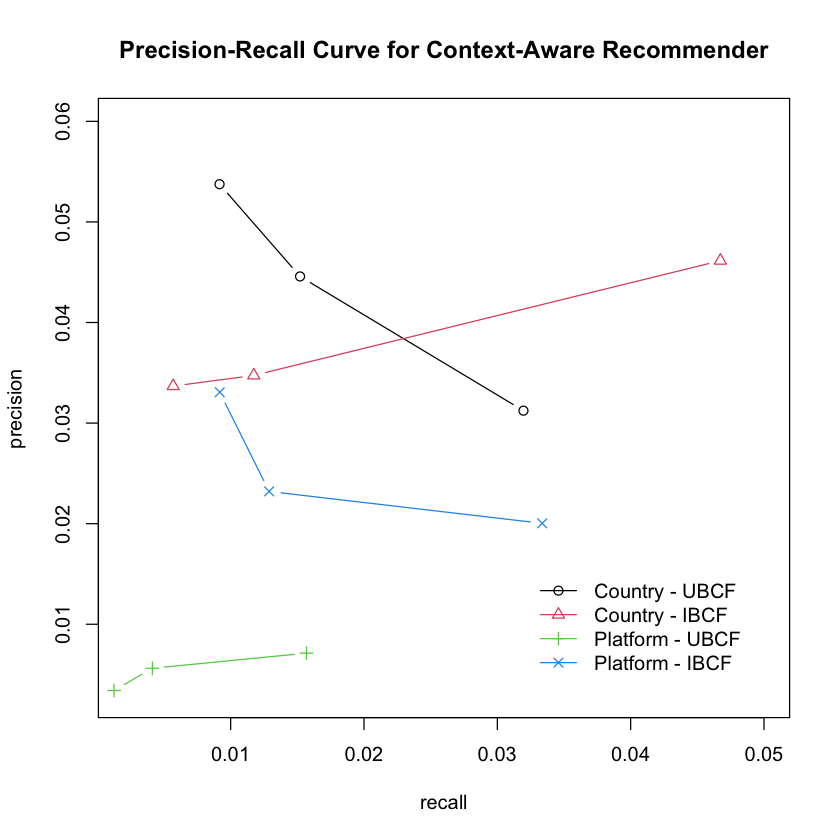

In [21]:
plot(final1[c("recall","precision")],main = "Precision-Recall Curve for Context-Aware Recommender",type='b',xlim=c(0.002,0.05),ylim=c(0.003,0.06))
lines(final2[c("recall","precision")],type = 'b',pch=2,col = 2)
lines(final3[c("recall","precision")],type = 'b',pch=3,col = 3)
lines(final4[c("recall","precision")],type = 'b',pch=4,col = 4)
legend("bottomright", inset = 0.05,
       legend = c("Country - UBCF", "Country - IBCF",'Platform - UBCF','Platform - IBCF'),
       bg = rgb(1, 0, 0, alpha = 0), # Legend background color
       box.col = "white",
       lty = 1,
       col = 1:4,
       pch = 1:4)


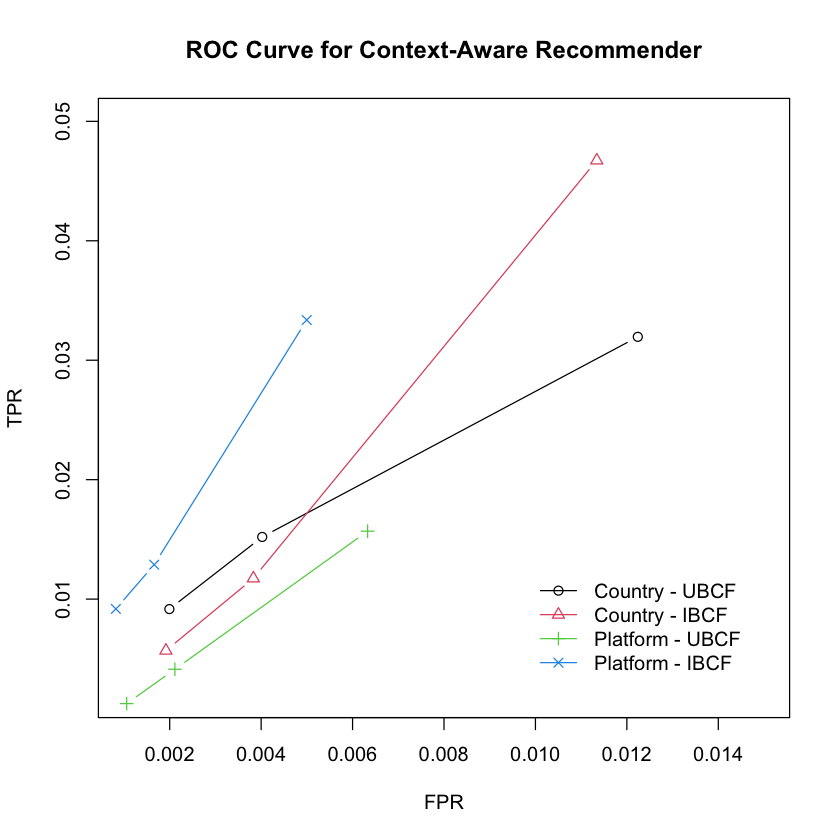

In [23]:
plot(final1[c("FPR","TPR")],main = "ROC Curve for Context-Aware Recommender",type='b',xlim=c(0.001,0.015),ylim=c(0.002,0.05),pch = 1, col = 1)
lines(final2[c("FPR","TPR")],type = 'b',pch=2,col = 2)
lines(final3[c("FPR","TPR")],type = 'b',pch=3,col = 3)
lines(final4[c("FPR","TPR")],type = 'b',pch=4,col = 4)
legend("bottomright", inset = 0.05,
       legend = c("Country - UBCF", "Country - IBCF",'Platform - UBCF','Platform - IBCF'),
       bg = rgb(1, 0, 0, alpha = 0), # Legend background color
       box.col = "white",
       lty = 1,
       col = 1:4,
       pch = 1:4)

The results are underwhelming, with the methods performing even worse than the original ones. We can conclude from this that the decision making of the costumers in this market is not very driven by the their country or the platform they're using. 

## Saving the Plots

In [24]:
setEPS()      
postscript("contextROC.eps")  

plot(final1[c("FPR","TPR")],main = "ROC Curve for Context-Aware Recommender",type='b',xlim=c(0.001,0.015),ylim=c(0.002,0.05),pch = 1, col = 1)
lines(final2[c("FPR","TPR")],type = 'b',pch=2,col = 2)
lines(final3[c("FPR","TPR")],type = 'b',pch=3,col = 3)
lines(final4[c("FPR","TPR")],type = 'b',pch=4,col = 4)
legend("bottomright", inset = 0.05,
       legend = c("Country - UBCF", "Country - IBCF",'Platform - UBCF','Platform - IBCF'),
       bg = rgb(1, 0, 0, alpha = 0), # Legend background color
       box.col = "white",
       lty = 1,
       col = 1:4,
       pch = 1:4)


dev.off()   

setEPS()      
postscript("contextPREC.eps")  
plot(final1[c("recall","precision")],main = "Precision-Recall Curve for Context-Aware Recommender",type='b',xlim=c(0.002,0.05),ylim=c(0.003,0.06))
lines(final2[c("recall","precision")],type = 'b',pch=2,col = 2)
lines(final3[c("recall","precision")],type = 'b',pch=3,col = 3)
lines(final4[c("recall","precision")],type = 'b',pch=4,col = 4)
legend("bottomright", inset = 0.05,
       legend = c("Country - UBCF", "Country - IBCF",'Platform - UBCF','Platform - IBCF'),
       bg = rgb(1, 0, 0, alpha = 0), # Legend background color
       box.col = "white",
       lty = 1,
       col = 1:4,
       pch = 1:4)
dev.off()   

pdf 
  2

pdf 
  2

# Conclusions and Future Work

The main conclusion of this work is that the Collaborative Filtering methods fail in such an environment, while AR recommendation prevails as a more versatile method. The Content-based and Context-aware alternatives implemented also do not yield satisfactory results. We conclude that more strict context-aware recommender are required to accurately model this niche of the fashion market, such as implementing more advanced algorithms like the Item Splitting method.

As for future work, we could try to implement a sequence mining algorithm using the \textit{purchase\_date} column in the dataset to organize the transactions by their time of purchase. It could also be useful to boost the recommendations using an hybrid model between CF or AR recommender and the Content-based recommender with the embeddings, as suggested in "The Importance of Brand Affinity in Luxury Fashion Recommendations”.